In [1]:
import numpy as np
import cv2
from patchify import patchify
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import os
from sklearn.preprocessing import MinMaxScaler,StandardScaler

Segmentation Models: using `keras` framework.


In [2]:
from PIL import Image

In [3]:
scaler = MinMaxScaler()

In [4]:
root_dir = 'Semantic segmentation dataset/'

patch_size = 256

image_dataset = []
for path,subdirs,files in os.walk(root_dir):
    # print(path)
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images = os.listdir(path)
        for i, image_name in enumerate(images):
            if image_name.endswith('.jpg'):
                image = cv2.imread(path+'/'+image_name,1)

                size_x = (image.shape[1]//patch_size)*patch_size
                size_y = (image.shape[0]//patch_size)*patch_size

                image = Image.fromarray(image)
                image = image.crop((0,0,size_x,size_y))
                image = np.array(image)

                # print("Now patchifying images: ", path+'/'+image_name)
                patches_img = patchify(image,(patch_size,patch_size,3),step=patch_size)

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                       single_patch_img = patches_img[i,j,:,:] 
                       single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                       single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                       image_dataset.append(single_patch_img)

In [5]:
image_dataset = np.array(image_dataset)

In [6]:
image_dataset.shape

(1305, 256, 256, 3)

In [7]:
root_dir = 'Semantic segmentation dataset/'

patch_size = 256

masks_dataset = []
for path,subdirs,files in os.walk(root_dir):
    # print(path)
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':
        mask = os.listdir(path)
        for i, mask_name in enumerate(mask):
            if mask_name.endswith('.png'):

                masks = cv2.imread(path+'/'+mask_name,1)
                masks = cv2.cvtColor(masks,cv2.COLOR_BGR2RGB)

                size_x = (masks.shape[1]//patch_size)*patch_size
                size_y = (masks.shape[0]//patch_size)*patch_size

                masks = Image.fromarray(masks)
                masks = masks.crop((0,0,size_x,size_y))
                masks = np.array(masks)

                # print("Now patchifying images: ", path+'/'+mask_name)
                patches_masks = patchify(masks,(patch_size,patch_size,3),step=patch_size)

                for i in range(patches_masks.shape[0]):
                    for j in range(patches_masks.shape[1]):
                       single_patch_masks = patches_masks[i,j,:,:] 
                       single_patch_masks = single_patch_masks[0] #Drop the extra unecessary dimension that patchify adds.                               
                       masks_dataset.append(single_patch_masks)

In [8]:
masks_dataset = np.array(masks_dataset)

In [9]:
masks_dataset.shape

(1305, 256, 256, 3)

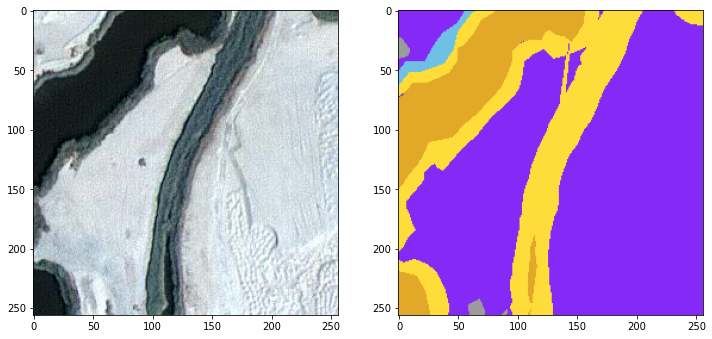

In [10]:
import random
import matplotlib.pyplot as plt
image_number = random.randint(0,len(image_dataset))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number],(patch_size,patch_size,3)))

plt.subplot(122)
plt.imshow(np.reshape(masks_dataset[image_number],(patch_size,patch_size,3)))
plt.show()

In [11]:
#Convert HEX to RGB array
# Try the following to understand how python handles hex values...
a=int('3C', 16)  #3C with base 16. Should return 60. 
print(a)
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

60


In [12]:
label = single_patch_masks

In [13]:
Land,Road,Building,Vegetation,Unlabeled

(array([132,  41, 246]),
 array([110, 193, 228]),
 array([ 60,  16, 152]),
 array([254, 221,  58]),
 array([155, 155, 155]))

In [14]:
def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label == Land,axis=-1)] = 1
    label_seg [np.all(label == Road,axis=-1)] = 2
    label_seg [np.all(label == Vegetation,axis=-1)] = 3
    label_seg [np.all(label == Water,axis=-1)] = 4
    label_seg [np.all(label == Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg


In [15]:
masks_dataset.shape,image_dataset.shape

((1305, 256, 256, 3), (1305, 256, 256, 3))

In [16]:
labels = []
for i in range(masks_dataset.shape[0]):
    label = rgb_to_2D_label(masks_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 
print(labels.shape)
print("Unique labels in label dataset are: ", np.unique(labels))

(1305, 256, 256, 1)
Unique labels in label dataset are:  [0 1 2 3 4 5]


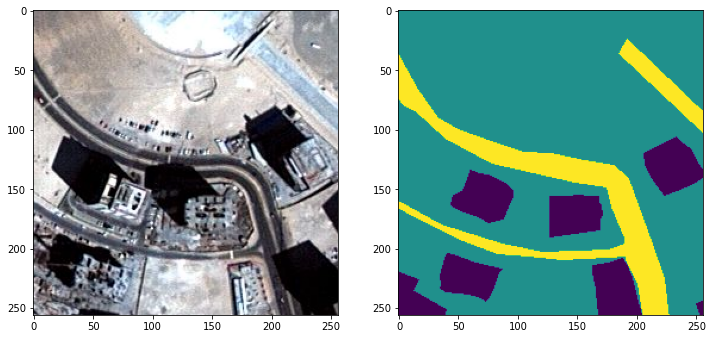

In [17]:
#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [18]:
n_classes = len(np.unique(labels))

In [19]:
from tensorflow.keras.utils import to_categorical

In [20]:
labels_categorical = to_categorical(labels,num_classes=n_classes)

In [21]:
from sklearn.model_selection import train_test_split
X_train,X_test, Y_train,Y_test = train_test_split(image_dataset,masks_dataset,shuffle=True,random_state=35,test_size=0.2)

In [22]:
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape,

((1044, 256, 256, 3),
 (261, 256, 256, 3),
 (1044, 256, 256, 3),
 (261, 256, 256, 3))

In [23]:
weights = [0.1666,0.1666,0.1666,0.1666,0.1666,0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1*focal_loss)

In [24]:
img_height = X_train.shape[1]
img_width = X_train.shape[2]
img_channels = X_train.shape[3]

In [25]:
from simple_multi_unet_model import multi_unet_model, jacard_coef

In [26]:
metrics = ['accuracy',jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes,IMG_HEIGHT=img_height,IMG_WIDTH=img_width,IMG_CHANNELS=img_channels)

In [27]:
model = get_model()

In [28]:
model.compile(optimizer='adam',loss=total_loss,metrics=metrics)

In [29]:
# model.summary()

In [35]:
!nvidia-smi

Fri Aug 19 12:07:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   43C    P8     3W /  N/A |   2318MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
tf.cast(X_train, tf.float32)

In [ ]:
history = model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=10,batch_size=64,shuffle=False,verbose=1)